Discard: Tests with conditional distributions by mapping from the hypercube to converse probability

In [1]:
# Makes it easier to debug
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import torch

In [2]:
import swyft
import pylab as plt
import numpy as np
import scipy

In [3]:
import swyft

In [4]:
class CrazyBound(swyft.Bound):
    def __init__(self, x, tail):
        self.x = x
        self.tail = tail
        
    def sample(self, N):
        x = self.x.unsqueeze(0).repeat(N, 1).cuda()
        s = self.tail.sample(x, N).detach().cpu().numpy()
        return s
    
    def __call__(self, u):
        return np.ones(len(u))
    
    @property
    def volume(self):
        return 1.
    
    def state_dict(self):
        return {"tag": "123"} 

In [5]:
class NormalRatio(torch.nn.Module):
    def __init__(self, *shape, th = 5):
        super().__init__()
        self.log_factor = torch.nn.Parameter(torch.zeros(*shape))
        self.log_sigma = torch.nn.Parameter(torch.zeros(*shape))
        self.th = th
    
    def forward(self, z, m):
        if z.reshape(-1)[0] < 0:  # TODO Copies occasionally
            N = len(z)
            #print(z.shape)
            #print(N)
            #print(m.shape)
            z[:] = self.sample(N, m)
        log_r = self.log_factor - 0.5*(z-m)**2/torch.exp(self.log_sigma)**2
        #print(self.log_sigma)
        return log_r
    
    def sample(self, N, m):
        """Sample constrained priors"""
        sigma = torch.exp(self.log_sigma)
        width = torch.minimum(2*self.th*sigma, torch.ones_like(m))
        lo = torch.maximum(m-0.5*width, torch.zeros_like(m))
        lo = torch.minimum(lo, 1-width)
        ret = torch.rand(*m.shape, device=m.device)*width+lo
        #print(ret.shape)
        return ret

nr = NormalRatio(1)
m = torch.rand(1, 4)

In [6]:
class View:
    def __init__(self, **shapes):
        self._shapes = shapes
        self._i0 = {}
        self._i1 = {}
        
        N = 0
        for key, value in shapes.items():
            n = np.prod(value)
            self._i0[key] = N
            self._i1[key] = N + n
            N += n
        
        self._N = N
        
    def __len__(self):
        return self._N

class Viewer:
    def __init__(self, view, u):
        self._view = view
        self._u = u
        
    def __getattr__(self, key):
        ucut = self._u[..., self._view._i0[key]:self._view._i1[key]]
        if type(ucut) == np.ndarray:
            return ucut.reshape(*self._u.shape[:-1], *self._view._shapes[key])  # TODO Redunadnt
        else:
            return ucut.reshape(*self._u.shape[:-1], *self._view._shapes[key])
    
    def __setattr__(self, key, value):
        if key[:1] == '_':
            object.__setattr__(self, key, value)
        else:
            if type(value) == np.ndarray:
                value_shaped = value.reshape(*self._u.shape[:-1], np.prod(self._view._shapes[key]))  # TODO Redundant
            else:
                value_shaped = value.reshape(*self._u.shape[:-1], np.prod(self._view._shapes[key]))
            self._u[..., self._view._i0[key]:self._view._i1[key]] = value_shaped
    
    def __len__(self):
        return self._view._N
    
    def __call__(self):
        return self._u

## Model

In [7]:
N = 100 # Number of data bins
SIGMA = 0.01  # Measurement uncertainty

In [8]:
view = View(a = (N,), b = (1,))

def model(v):
    vv = Viewer(view, v)
    x = vv.a*vv.b
    return dict(x=x)
    
# Noise model
def noise(sim, v):
    noise = np.random.randn(N)*SIGMA
    return dict(x = sim['x'] + noise)

# Prior
def transform(u):
    v = np.zeros_like(u)
    vv = Viewer(view, v)
    uv = Viewer(view, u)
    vv.a = scipy.stats.norm(0., 1.).ppf(uv.a)
    vv.b = uv.b*0.001 + 1.
    return v

NPAR = N +1

## Network

In [9]:
class RatioSampler(swyft.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rb = NormalRatio(1)
        self.ra = NormalRatio(N)
        self.get_mb = torch.nn.Sequential(
            torch.nn.Linear(N, 32),
            #torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 256),
            #torch.nn.BatchNorm1d(256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            #torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid()
        )
        self.get_ma = torch.nn.Sequential(
            #swyft.networks.linear.LinearWithChannel(N, 1, 1),
            torch.nn.Linear(1, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 1),
            #torch.nn.ReLU(),
            #swyft.networks.linear.LinearWithChannel(N, 32, 1),
            torch.nn.Sigmoid()  # stay within [0, 1]
        )
        self.get_bias = torch.nn.Linear(1, N, bias = False)
        #self.r1 = NormalRatio(1)
        #self.v = View(a = (100,), b = (1,))
        self.bn = torch.nn.BatchNorm1d(N, eps = 1., momentum = 0.1, affine = False)
        self.bn2 = torch.nn.BatchNorm1d(N, momentum = 0.01, affine = False, eps = 1.)
    
    def embedding(self, x):
        return x
    
    def sample(self, x, N):
        z = x.new(N, NPAR)*0-1
        self.forward(x, z)
        return z
    
    def forward(self, x, u):
        uv = Viewer(view, u)
        f = self.embedding(x)
        
        f_sorted = torch.sort(f, dim=-1)[0]
        #f_sorted = self.bn2(f_sorted)
        mb = self.get_mb(f_sorted)
        #print(uv.b, mb)
        rb = self.rb(uv.b, mb)
        #print(rb)
        
        ma = self.get_ma(f.unsqueeze(-1)).squeeze(-1)
        bias = self.get_bias(1/uv.b)
        bias = self.bn(bias)*0
        
        #if uv.a.reshape(-1)[0] >= 0.:
        #    uva_estimate = torch.distributions.Normal(0, 1).icdf(uv.a)
        #else:
        #    uva_estimate = uv.a
        #uva_estimate = uv.a
        ra = self.ra(uv.a, ma + bias)
        #uv.a[:] = torch.distributions.Normal(0, 1).cdf(uva_estimate)
        
        r = torch.hstack([ra, rb])
        return r

In [147]:
#torch.distributions.Normal(0, 1).cdf(torch.rand(3, 4, 5)).shape
torch.distributions.Normal(0, 1).icdf(2*torch.rand(2))

tensor([-0.0194, -0.0516])

In [148]:
def run_round(ntrain, bound = None, max_epochs = 3):
    store = swyft.MemoryStore(sim)
    store.add(ntrain, prior, bound)
    store.simulate()
    dataset = swyft.Dataset(ntrain*10000, prior, store, bound = bound, simhook = noise, check_coverage = False)
    print("Dataset size:", len(dataset))
    post = swyft.Posteriors(dataset)
    partition = range(NPAR)
    post.add(partition, device='cuda', head_args = dict(online_norm = False), tail = RatioSampler)
    post.train(partition, max_epochs = max_epochs, scheduler_args = dict(patience = 1, factor = 0.5), early_stopping_patience = 5, 
               batch_size = 64, optimizer_args = dict(lr = 0.01))
    tail = list(post._ratios.items())[0][1].tail
    bound = CrazyBound(x0, tail)
    return dict(post=post, store=store, dataset=dataset, tail=tail, bound=bound)

In [149]:
def plot_dataset(dataset):
    for i in range(200):
        plt.plot(dataset[i][0]['x'], color='0.5')
    plt.plot(x0, marker='x', color='r', lw=2)

In [179]:
def plot_tail(tail, u0 = None, i0 = 0, i1 = 10, scaled = False):
    NS = 1000
    s = tail.sample(x0.unsqueeze(0).repeat(NS, 1).cuda(), NS).detach().cpu().numpy()
    for i in range(i0, i1):
        if scaled:
            plt.scatter(s[:,-1], scipy.stats.norm(0., 1.).ppf(s[:,i]))
        else:
            plt.scatter(s[:,-1], s[:,i])
    plt.xlim([0, 1])
    if not scaled:
        plt.ylim([0, 1])
    if u0 is not None:
        plt.axvline(u0[-1])
        if scaled:
            s = scipy.stats.norm(0., 1.).ppf(u0[i0:i1])
            plt.scatter(u0[-1]*np.ones(i1-i0), s, marker='.', color='k')
        else:
            plt.scatter(u0[-1]*np.ones(i1-i0), u0[i0:i1], marker='.', color='k')

## Analysis

In [151]:
sim = swyft.Simulator(model, NPAR, dict(x=(N,)))
prior = swyft.Prior(transform, NPAR, n = 1000)

In [152]:
store = swyft.MemoryStore(sim)
store.add(10, prior, None)
store.simulate()
dataset = swyft.Dataset(10, prior, store, bound = None, simhook = noise, check_coverage = False)
x0 = dataset[0][0]['x']
u0 = dataset[0][1]

Creating new store.
Store: Adding 2 new samples to simulator store.


/home/weniger/swyft/swyft/bounds/prior.py:172: RuntimeWarning: invalid value encountered in subtract
  u[:, i] - (du / 2), self._grid, self._table[i], left=None, right=None


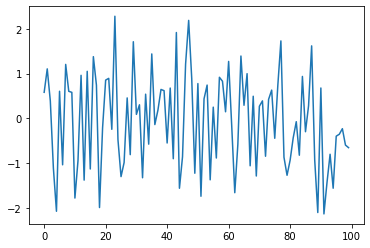

In [153]:
plt.plot(x0)

### Round 1

In [168]:
round1 = run_round(10000, max_epochs = 50)

Creating new store.


/home/weniger/swyft/swyft/bounds/prior.py:172: RuntimeWarning: invalid value encountered in subtract
  u[:, i] - (du / 2), self._grid, self._table[i], left=None, right=None


Store: Adding 8274 new samples to simulator store.
Dataset size: 8274
Training: lr=0.0025, Epoch=12, VL=23.46, TL=23.94


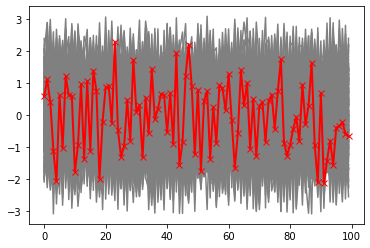

In [169]:
plot_dataset(round1['dataset'])

(-4.0, 4.0)

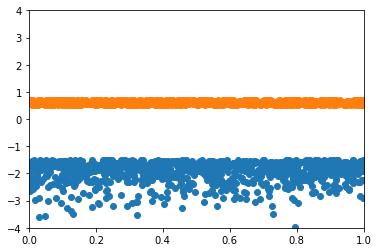

In [181]:
plot_tail(round1['tail'], i0 = 4, i1 = 6, scaled = True)
plt.ylim([-4, 4])

### Round 2

In [113]:
round2 = run_round(10000, max_epochs = 10, bound = round1['bound'])

Creating new store.


/home/weniger/swyft/swyft/bounds/prior.py:172: RuntimeWarning: invalid value encountered in subtract
  u[:, i] - (du / 2), self._grid, self._table[i], left=None, right=None


Store: Adding 8127 new samples to simulator store.
Dataset size: 8127
Training: lr=0.005, Epoch=10, VL=43.09, TL=41.92


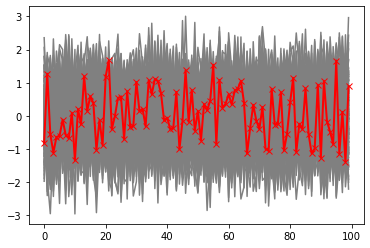

In [126]:
plot_dataset(round2['dataset'])

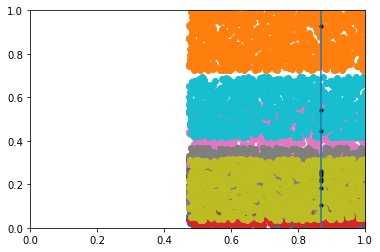

In [127]:
plot_tail(round2['tail'], u0=u0)

### Round 3

In [ ]:
round3 = run_round(10000, max_epochs = 10, bound = round2['bound'])

Creating new store.


/home/weniger/swyft/swyft/bounds/prior.py:172: RuntimeWarning: invalid value encountered in subtract
  u[:, i] - (du / 2), self._grid, self._table[i], left=None, right=None


Store: Adding 8839 new samples to simulator store.


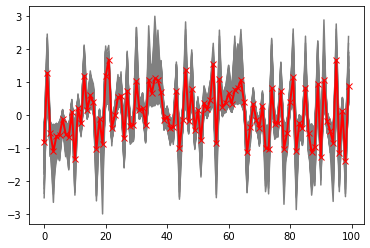

In [128]:
plot_dataset(round3['dataset'])

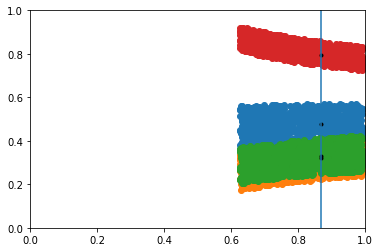

In [136]:
plot_tail(round3['tail'], u0=u0, i0=40, i1=44)

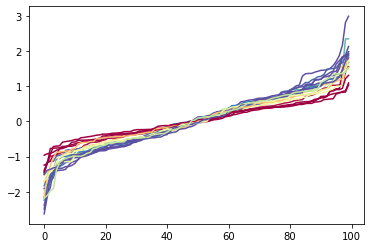

In [130]:
import matplotlib
cmap = matplotlib.cm.get_cmap("Spectral")

dataset = round3['dataset']
for i in range(20):
    x = dataset[i][0]['x'].numpy()
    uu = dataset[i][1][-1].item()
    uu = (uu-0.6)*3
    x = np.sort(x)
    c = cmap(uu)
    plt.plot(x, color=c)

### Round 4

In [47]:
round4 = run_round(10000, max_epochs = 10, bound = round3['bound'])

Creating new store.


/home/weniger/swyft/swyft/bounds/prior.py:172: RuntimeWarning: invalid value encountered in subtract
  u[:, i] - (du / 2), self._grid, self._table[i], left=None, right=None


Store: Adding 9192 new samples to simulator store.
Dataset size: 9192
Training: lr=0.005, Epoch=10, VL=62.63, TL=56.94


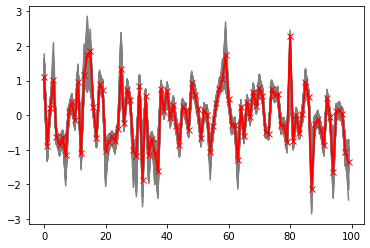

In [48]:
plot_dataset(round4['dataset'])

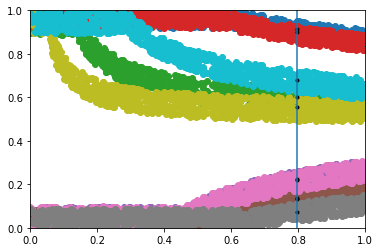

In [49]:
plot_tail(round4['tail'], u0 = u0)

### Round 5

In [35]:
round5 = run_round(10000, max_epochs = 100, bound = round4['bound'])

Creating new store.


/home/weniger/swyft/swyft/bounds/prior.py:172: RuntimeWarning: invalid value encountered in subtract
  u[:, i] - (du / 2), self._grid, self._table[i], left=None, right=None


Store: Adding 8078 new samples to simulator store.
Dataset size: 8078
Training: lr=7.8e-05, Epoch=100, VL=121.1, TL=123.4


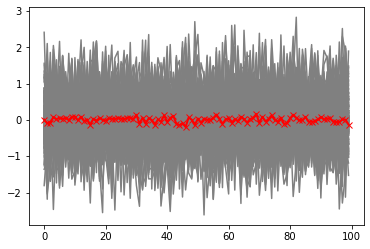

In [36]:
plot_dataset(round5['dataset'])

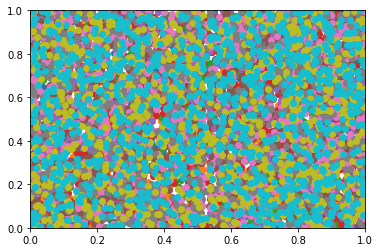

In [37]:
plot_tail(round5['tail'])

### Round 6

In [38]:
round6 = run_round(10000, max_epochs = 100, bound = round5['bound'])

Creating new store.


/home/weniger/swyft/swyft/bounds/prior.py:172: RuntimeWarning: invalid value encountered in subtract
  u[:, i] - (du / 2), self._grid, self._table[i], left=None, right=None


Store: Adding 8062 new samples to simulator store.
Dataset size: 8062
Training: lr=2.4e-06, Epoch=97, VL=88.78, TL=87.92


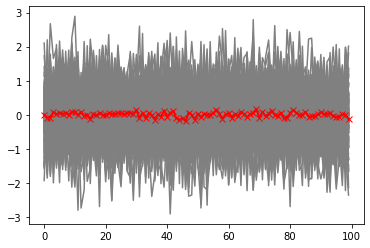

In [39]:
plot_dataset(round6['dataset'])

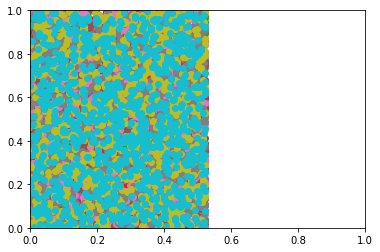

In [41]:
plot_tail(round6['tail'], i0 = 10, i1= 20 )